In [1]:
import torch

## Notebook objectives
1. Investigate why manual training loop loss values are different from PyTorch training loop loss values.

# Define the neural net model

In [2]:
class NeuralNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NeuralNet, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

    def backward(self, loss):
        loss.backward()

In [3]:
input_dim = 10
hidden_dim = 5
output_dim = 1
n_samples = 25

# Creating a sample train, val and test dataset

In [4]:
g = torch.Generator().manual_seed(42)
g2 = torch.Generator().manual_seed(2145521414)
g3 = torch.Generator().manual_seed(4544313143143)

# torch.random.manual_seed(42)

train_X = torch.randn((n_samples, input_dim), generator=g)
train_y = torch.randn((n_samples, output_dim), generator=g)
train_y = torch.where(train_y > 0, 1, 0).squeeze()

val_X = torch.randn((n_samples, input_dim), generator=g2)
val_y = torch.randn((n_samples, output_dim), generator=g2)
val_y = torch.where(val_y > 0, 1, 0).squeeze()

test_X = torch.randn((n_samples, input_dim), generator=g3)
test_y = torch.randn((n_samples, output_dim), generator=g3)
test_y = torch.where(test_y > 0, 1, 0).squeeze()

# print(train_X, train_y)


# Run the forward pass

Firstly, when we initialize a neural net with `clf = NeuralNet(...)`, the weights inside the net are being initialized and hence randomness is creating variability in each run. We remove this variability by setting `torch.manual_seed()` prior to the neural net initialization.

We break after one forward pass to inspect the values.

In [5]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

torch.manual_seed(42)
clf = NeuralNet(input_dim, hidden_dim, output_dim)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = torch.square(torch.abs(y_pred.squeeze() - train_y.float())).sum()

    print(f"train_loss: {loss: 3f}"); break
    # backward pass
    clf.backward(loss)

    # update the weights by a small amount
    for param in clf.parameters():
        if param.grad is not None:
            param.data -= 0.00001 * param.grad.data

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)
    val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")
    
    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

train_loss:  10.164648


In [6]:
y_pred, train_y, loss

(tensor([[ 0.1601],
         [ 0.2117],
         [ 0.0905],
         [ 0.0282],
         [ 0.0256],
         [ 0.0787],
         [-0.0855],
         [ 0.0284],
         [ 0.0214],
         [ 0.0479],
         [ 0.3113],
         [ 0.0727],
         [-0.0432],
         [ 0.0119],
         [ 0.2090],
         [ 0.0871],
         [ 0.0282],
         [ 0.3001],
         [ 0.0228],
         [ 0.2292],
         [ 0.1318],
         [ 0.0537],
         [ 0.2359],
         [ 0.0897],
         [ 0.0282]], grad_fn=<AddmmBackward0>),
 tensor([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
         1]),
 tensor(10.1646, grad_fn=<SumBackward0>))

In [7]:
torch.set_printoptions(sci_mode=False)
torch.square(torch.abs(y_pred.squeeze() - train_y.float())).sum()

tensor(10.1646, grad_fn=<SumBackward0>)

## PyTorch approach

In [8]:
import random
import numpy as np

torch.manual_seed(42)

w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

clf = NeuralNet(input_dim, hidden_dim, output_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.00001)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = criterion(y_pred.squeeze(), train_y.float())
    
    print(f"train_loss: {loss: 3f}"); break

    # backward pass
    loss.backward()

    # update the weights by a small amount
    optimizer.step()

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)

    val_loss = criterion(val_preds.squeeze(), val_y.float())
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

train_loss:  0.406586


The loss values are different and that means something is off in my codebase. It looks like I'm not dividing my loss with number of samples. I am doing squared loss but not mean squared loss.

In [9]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

torch.manual_seed(42)
clf = NeuralNet(input_dim, hidden_dim, output_dim)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = torch.square(torch.abs(y_pred.squeeze() - train_y.float())).sum() / len(train_y)

    print(f"train_loss: {loss: 3f}"); break
    # backward pass
    clf.backward(loss)

    # update the weights by a small amount
    for param in clf.parameters():
        if param.grad is not None:
            param.data -= 0.00001 * param.grad.data

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)
    val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")
    
    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

train_loss:  0.406586


Great! The loss values look the same now.n_samples

Instead of doing sum and division, can I just do `mean()`?

In [10]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

torch.manual_seed(42)
clf = NeuralNet(input_dim, hidden_dim, output_dim)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = torch.square(torch.abs(y_pred.squeeze() - train_y.float())).mean()

    print(f"train_loss: {loss: 3f}"); break
    # backward pass
    clf.backward(loss)

    # update the weights by a small amount
    for param in clf.parameters():
        if param.grad is not None:
            param.data -= 0.00001 * param.grad.data

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)
    val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")
    
    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

train_loss:  0.406586


The loss values seem to be aligned now. 

In [11]:
g = torch.Generator().manual_seed(42)
g2 = torch.Generator().manual_seed(2145521414)
g3 = torch.Generator().manual_seed(4544313143143)

train_X = torch.randn((n_samples, input_dim), generator=g)
train_y = torch.randn((n_samples, output_dim), generator=g)
train_y = torch.where(train_y > 0, 1, 0).squeeze()

val_X = torch.randn((n_samples, input_dim), generator=g2)
val_y = torch.randn((n_samples, output_dim), generator=g2)
val_y = torch.where(val_y > 0, 1, 0).squeeze()

test_X = torch.randn((n_samples, input_dim), generator=g3)
test_y = torch.randn((n_samples, output_dim), generator=g3)
test_y = torch.where(test_y > 0, 1, 0).squeeze()

# print(train_X, train_y)


In [18]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

torch.manual_seed(42)
clf = NeuralNet(input_dim, hidden_dim, output_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.0001)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = criterion(y_pred.squeeze(), train_y.float())

    # reset the gradients
    optimizer.zero_grad()
    
    # backward pass
    loss.backward()

    # update the weights by a small amount
    optimizer.step()

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)

    val_loss = criterion(val_preds.squeeze(), val_y.float())
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch:   0 | train_loss:  0.406586 | val_loss:  0.509026
 epoch:   1 | train_loss:  0.406491 | val_loss:  0.508928
 epoch:   2 | train_loss:  0.406397 | val_loss:  0.508829
 epoch:   3 | train_loss:  0.406302 | val_loss:  0.508730
 epoch:   4 | train_loss:  0.406208 | val_loss:  0.508632
 epoch:   5 | train_loss:  0.406114 | val_loss:  0.508533
 epoch:   6 | train_loss:  0.406019 | val_loss:  0.508435
 epoch:   7 | train_loss:  0.405925 | val_loss:  0.508336
 epoch:   8 | train_loss:  0.405831 | val_loss:  0.508238
 epoch:   9 | train_loss:  0.405737 | val_loss:  0.508140
 epoch:  10 | train_loss:  0.405642 | val_loss:  0.508041
 epoch:  11 | train_loss:  0.405548 | val_loss:  0.507943
 epoch:  12 | train_loss:  0.405454 | val_loss:  0.507845
 epoch:  13 | train_loss:  0.405360 | val_loss:  0.507747
 epoch:  14 | train_loss:  0.405266 | val_loss:  0.507649
 epoch:  15 | train_loss:  0.405172 | val_loss:  0.507551
 epoch:  16 | train_loss:  0.405079 | val_loss:  0.507453
 epoch:  17 | 

To observe a model summary just like the amazing summary by tensorflow, we use `torchinfo` library for simplicity.

In [19]:
from torchinfo import summary

model = NeuralNet(input_dim=10, hidden_dim=5, output_dim=1)
summary(model, input_size=(1, 10))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNet                                [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 5]                    55
│    └─ReLU: 2-2                         [1, 5]                    --
│    └─Linear: 2-3                       [1, 1]                    6
Total params: 61
Trainable params: 61
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [20]:
import lovely_tensors as lt
lt.monkey_patch()

train_X

tensor[25, 10] n=250 x∈[-2.510, 2.218] μ=0.052 σ=0.987

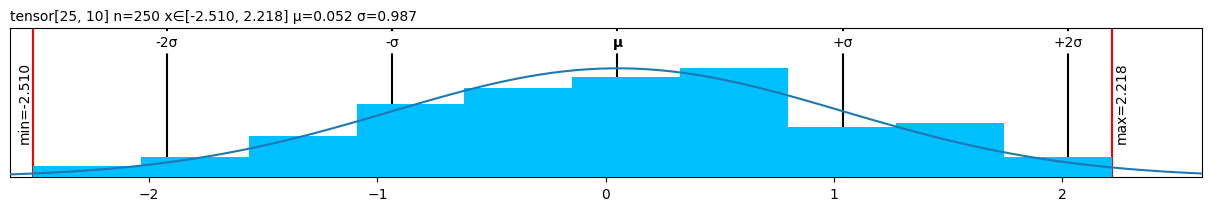

In [21]:
train_X.plt

# Plot the losses and grad norms

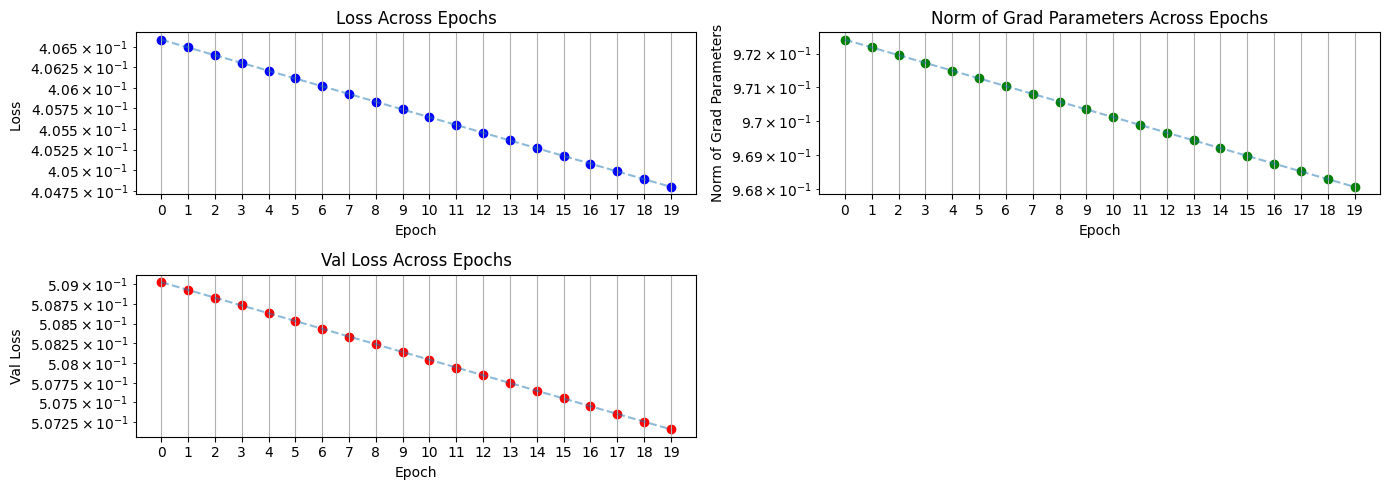

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2, 2, figsize=(14, 5))

epochs = list(range(n_epochs))

# Plot means
axes[0, 0].scatter(epochs, losses, color='blue')
axes[0, 0].plot(epochs, losses, linestyle='dashed', alpha=0.5)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss ')
axes[0, 0].set_title('Loss Across Epochs')
axes[0, 0].set_xticks(epochs)
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True)

# Plot norms (gradient norms) in axes[0, 1]
axes[0, 1].scatter(epochs, g_norms, color='green')
axes[0, 1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Norm of Grad Parameters')
axes[0, 1].set_title('Norm of Grad Parameters Across Epochs')
axes[0, 1].set_xticks(epochs)
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True)

# Plot validation loss in axes[1, 0]
axes[1, 0].scatter(epochs, val_losses, color='red')
axes[1, 0].plot(epochs, val_losses, linestyle='dashed', alpha=0.5)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Val Loss')
axes[1, 0].set_title('Val Loss Across Epochs')
axes[1, 0].set_xticks(epochs)
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

# Remove the 4th plot (axes[1, 1])
fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()

Looking at the loss curves, it looks like we can increase out learning rate! Let's try that.

# Tuning the learning rate

In [23]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

torch.manual_seed(42)
clf = NeuralNet(input_dim, hidden_dim, output_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.01)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = criterion(y_pred.squeeze(), train_y.float())

    # reset the gradients
    optimizer.zero_grad()
    
    # backward pass
    loss.backward()

    # update the weights by a small amount
    optimizer.step()

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)

    val_loss = criterion(val_preds.squeeze(), val_y.float())
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch:   0 | train_loss:  0.406586 | val_loss:  0.499383
 epoch:   1 | train_loss:  0.397242 | val_loss:  0.490152
 epoch:   2 | train_loss:  0.388333 | val_loss:  0.481407
 epoch:   3 | train_loss:  0.379840 | val_loss:  0.473127
 epoch:   4 | train_loss:  0.371743 | val_loss:  0.465288
 epoch:   5 | train_loss:  0.364022 | val_loss:  0.457870
 epoch:   6 | train_loss:  0.356661 | val_loss:  0.450853
 epoch:   7 | train_loss:  0.349643 | val_loss:  0.444219
 epoch:   8 | train_loss:  0.342951 | val_loss:  0.437946
 epoch:   9 | train_loss:  0.336569 | val_loss:  0.432014
 epoch:  10 | train_loss:  0.330483 | val_loss:  0.426411
 epoch:  11 | train_loss:  0.324679 | val_loss:  0.421122
 epoch:  12 | train_loss:  0.319144 | val_loss:  0.416132
 epoch:  13 | train_loss:  0.313864 | val_loss:  0.411426
 epoch:  14 | train_loss:  0.308827 | val_loss:  0.406989
 epoch:  15 | train_loss:  0.304022 | val_loss:  0.402807
 epoch:  16 | train_loss:  0.299437 | val_loss:  0.398870
 epoch:  17 | 

Let's increase it a bit more!

In [24]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

torch.manual_seed(42)
clf = NeuralNet(input_dim, hidden_dim, output_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.1)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = criterion(y_pred.squeeze(), train_y.float())

    # reset the gradients
    optimizer.zero_grad()
    
    # backward pass
    loss.backward()

    # update the weights by a small amount
    optimizer.step()

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)

    val_loss = criterion(val_preds.squeeze(), val_y.float())
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch:   0 | train_loss:  0.406586 | val_loss:  0.424067
 epoch:   1 | train_loss:  0.323300 | val_loss:  0.379412
 epoch:   2 | train_loss:  0.274812 | val_loss:  0.357850
 epoch:   3 | train_loss:  0.246442 | val_loss:  0.349071
 epoch:   4 | train_loss:  0.229258 | val_loss:  0.346868
 epoch:   5 | train_loss:  0.218043 | val_loss:  0.348144
 epoch:   6 | train_loss:  0.210040 | val_loss:  0.351201
 epoch:   7 | train_loss:  0.203769 | val_loss:  0.355187
 epoch:   8 | train_loss:  0.198328 | val_loss:  0.359298
 epoch:   9 | train_loss:  0.193037 | val_loss:  0.363732
 epoch:  10 | train_loss:  0.188206 | val_loss:  0.368299
 epoch:  11 | train_loss:  0.183702 | val_loss:  0.373062
 epoch:  12 | train_loss:  0.179340 | val_loss:  0.378976
 epoch:  13 | train_loss:  0.172634 | val_loss:  0.385019
 epoch:  14 | train_loss:  0.166742 | val_loss:  0.391289
 epoch:  15 | train_loss:  0.161202 | val_loss:  0.397649
 epoch:  16 | train_loss:  0.155918 | val_loss:  0.404105
 epoch:  17 | 

Okay, now we're overfitting. 0.01 seems to be good.

In [25]:
w_means = []
w_norms = []
g_means = []
g_norms = []
losses  = []
val_losses = []

input_dim = 10
hidden_dim=5
output_dim = 1
n_samples = 25

torch.manual_seed(42)
clf = NeuralNet(input_dim, hidden_dim, output_dim)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.01)

n_epochs = 20
for i in range(n_epochs):
    y_pred = clf(train_X)
    loss = criterion(y_pred.squeeze(), train_y.float())

    # reset the gradients
    optimizer.zero_grad()
    
    # backward pass
    loss.backward()

    # update the weights by a small amount
    optimizer.step()

    # eval
    with torch.no_grad():
        val_preds = clf(val_X)

    val_loss = criterion(val_preds.squeeze(), val_y.float())
    # val_loss = torch.square(torch.abs(val_preds - val_y)).sum()

    print(f" epoch: {i:3d} | train_loss: {loss: 3f} | val_loss: {val_loss: 3f}")

    all_w_params = torch.cat([p.data.view(-1) for p in clf.parameters()])
    w_means.append(torch.mean(all_w_params).item())
    w_norms.append(torch.norm(all_w_params).item())

    all_grad_params = torch.cat([p.grad.data.view(-1) for p in clf.parameters()])
    g_means.append(torch.mean(all_grad_params).item())
    g_norms.append(torch.norm(all_grad_params).item())

    losses.append(loss.item())
    val_losses.append(val_loss.item())

 epoch:   0 | train_loss:  0.406586 | val_loss:  0.499383
 epoch:   1 | train_loss:  0.397242 | val_loss:  0.490152
 epoch:   2 | train_loss:  0.388333 | val_loss:  0.481407
 epoch:   3 | train_loss:  0.379840 | val_loss:  0.473127
 epoch:   4 | train_loss:  0.371743 | val_loss:  0.465288
 epoch:   5 | train_loss:  0.364022 | val_loss:  0.457870
 epoch:   6 | train_loss:  0.356661 | val_loss:  0.450853
 epoch:   7 | train_loss:  0.349643 | val_loss:  0.444219
 epoch:   8 | train_loss:  0.342951 | val_loss:  0.437946
 epoch:   9 | train_loss:  0.336569 | val_loss:  0.432014
 epoch:  10 | train_loss:  0.330483 | val_loss:  0.426411
 epoch:  11 | train_loss:  0.324679 | val_loss:  0.421122
 epoch:  12 | train_loss:  0.319144 | val_loss:  0.416132
 epoch:  13 | train_loss:  0.313864 | val_loss:  0.411426
 epoch:  14 | train_loss:  0.308827 | val_loss:  0.406989
 epoch:  15 | train_loss:  0.304022 | val_loss:  0.402807
 epoch:  16 | train_loss:  0.299437 | val_loss:  0.398870
 epoch:  17 | 

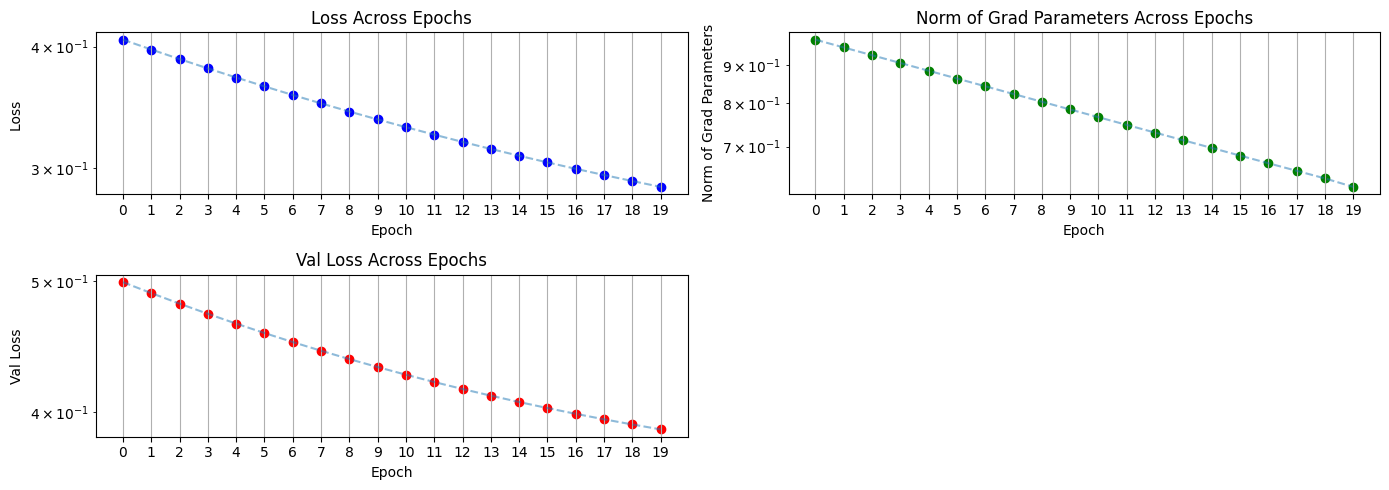

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(2, 2, figsize=(14, 5))

epochs = list(range(n_epochs))

# Plot means
axes[0, 0].scatter(epochs, losses, color='blue')
axes[0, 0].plot(epochs, losses, linestyle='dashed', alpha=0.5)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss ')
axes[0, 0].set_title('Loss Across Epochs')
axes[0, 0].set_xticks(epochs)
axes[0, 0].set_yscale('log')
axes[0, 0].grid(True)

# Plot norms (gradient norms) in axes[0, 1]
axes[0, 1].scatter(epochs, g_norms, color='green')
axes[0, 1].plot(epochs, g_norms, linestyle='dashed', alpha=0.5)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Norm of Grad Parameters')
axes[0, 1].set_title('Norm of Grad Parameters Across Epochs')
axes[0, 1].set_xticks(epochs)
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True)

# Plot validation loss in axes[1, 0]
axes[1, 0].scatter(epochs, val_losses, color='red')
axes[1, 0].plot(epochs, val_losses, linestyle='dashed', alpha=0.5)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Val Loss')
axes[1, 0].set_title('Val Loss Across Epochs')
axes[1, 0].set_xticks(epochs)
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

# Remove the 4th plot (axes[1, 1])
fig.delaxes(axes[1, 1])

plt.tight_layout()
plt.show()